In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model as lm
import seaborn as sns

In [7]:
x_1 = np.random.uniform(10,40,100)
x_2 = np.random.uniform(-50,20,100)
x_3 = np.random.uniform(20,60,100)
x_4 = np.random.uniform(10,40,100)
x_5 = np.random.uniform(-50,20,100)
x_6 = np.random.uniform(20,60,100)
epsilon = np.random.normal(0,10,100)

In [31]:
df = pd.DataFrame(epsilon,columns=['epsilon'])
df.describe(include='all').transpose()

,count,mean,std,min,25%,50%,75%,max
epsilon,100.0,-1.010277,10.177064,-33.489612,-7.913786,-2.283365,5.619137,24.046536


In [8]:
y=-30+1.3*x_1+1.6*x_2+1.1*x_3+0.7*x_4-2.1*x_5-0.9*x_6+epsilon

<Axes: >

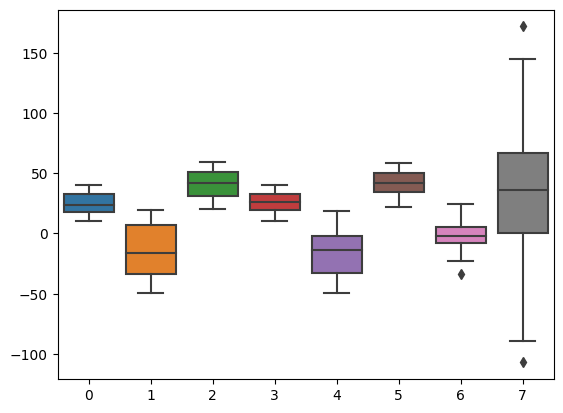

In [27]:
sns.boxplot([x_1,x_2,x_3,x_4,x_5,x_6,epsilon,y],orient='v')

In [12]:
X_ols=pd.DataFrame()
X_ols['Constant']=pd.Series(np.ones(100))
X_ols['X1'] = pd.Series(x_1)
X_ols['X2'] = pd.Series(x_2)
X_ols['X3'] = pd.Series(x_3)
X_ols['X4'] = pd.Series(x_4)
X_ols['X5'] = pd.Series(x_5)
X_ols['X6'] = pd.Series(x_6)

In [13]:
model_reg = sm.OLS(y,X_ols).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     462.4
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           6.21e-67
Time:                        19:42:51   Log-Likelihood:                -371.30
No. Observations:                 100   AIC:                             756.6
Df Residuals:                      93   BIC:                             774.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -22.3079      7.441     -2.998      0.003     -37.084      -7.532
X1             1.3622      0.125     10.889      0.000       1.114       1.611
X2             1.5801      0.050     31.679      0.000       1.481       1.679
X3             1.1005      0.089     12.345      0.000       0.923       1.278
X4             0.6429      0.124      5.201      0.000       0.397       0.888
X5            -2.0665      0.054    -38.566      0.000      -2.173      -1.960
X6            -1.1048      0.106    -10.399      0.000      -1.316      -0.894
==============================================================================
Omnibus:                        1.687   Durbin-Watson:                   2.271
Prob(Omnibus):                  0.430   Jarque-Bera (JB):                1.169
Skew:                           0.232   Prob(JB):                        0.557
Kurtosis:                       3.255   Cond. No.                         525.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [17]:
# Now we add some unrelated coefficients
x_7 = np.random.uniform(10,40,100)
x_8 = np.random.uniform(-50,20,100)
x_9 = np.random.uniform(20,60,100)
x_10 = np.random.uniform(10,40,100)
x_11 = np.random.uniform(-50,20,100)
x_12 = np.random.uniform(20,60,100)

In [18]:
X_ext = pd.DataFrame()
X_ext['Constant']=pd.Series(np.ones(100))
X_ext['X1'] = pd.Series(x_1)
X_ext['X2'] = pd.Series(x_2)
X_ext['X3'] = pd.Series(x_3)
X_ext['X4'] = pd.Series(x_4)
X_ext['X5'] = pd.Series(x_5)
X_ext['X6'] = pd.Series(x_6)
X_ext['X7'] = pd.Series(x_7)
X_ext['X8'] = pd.Series(x_8)
X_ext['X9'] = pd.Series(x_9)
X_ext['X10'] = pd.Series(x_10)
X_ext['X11'] = pd.Series(x_11)
X_ext['X12'] = pd.Series(x_12)

In [19]:
model_reg = sm.OLS(y,X_ext).fit()
model_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     226.3
Date:                Mon, 02 Oct 2023   Prob (F-statistic):           3.92e-60
Time:                        19:44:32   Log-Likelihood:                -369.12
No. Observations:                 100   AIC:                             764.2
Df Residuals:                      87   BIC:                             798.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -24.7738      9.929     -2.495      0.014     -44.510      -5.038
X1             1.3515      0.131     10.333      0.000       1.091       1.611
X2             1.5788      0.052     30.545      0.000       1.476       1.682
X3             1.0628      0.096     11.089      0.000       0.872       1.253
X4             0.5762      0.135      4.266      0.000       0.308       0.845
X5            -2.0587      0.056    -36.946      0.000      -2.169      -1.948
X6            -1.0810      0.110     -9.872      0.000      -1.299      -0.863
X7             0.0431      0.130      0.330      0.742      -0.216       0.302
X8             0.0251      0.062      0.406      0.686      -0.098       0.148
X9            -0.0028      0.104     -0.027      0.978      -0.209       0.204
X10           -0.0035      0.122     -0.028      0.977      -0.246       0.239
X11            0.0666      0.062      1.071      0.287      -0.057       0.190
X12            0.1317      0.098      1.341      0.183      -0.063       0.327
==============================================================================
Omnibus:                        0.959   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.619   Jarque-Bera (JB):                0.816
Skew:                           0.221   Prob(JB):                        0.665
Kurtosis:                       2.964   Cond. No.                         968.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# When we input the matrix, we don't need to add the column of ones because \
# Lasso automatically takes it into account

X_ext = X_ext.drop(columns=['Constant'])
model_lasso = lm.Lasso(alpha=1).fit(X_ext,y)
model_lasso.coef_

C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

array([ 1.33437814,  1.5759699 ,  1.05149651,  0.56556888, -2.05620864,
       -1.0700877 ,  0.02725334,  0.02226372, -0.        ,  0.        ,
        0.06687765,  0.12694334])

In [21]:
model_lasso = lm.Lasso(alpha=10).fit(X_ext,y)
model_lasso.coef_

C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

array([ 1.16889948,  1.55158268,  0.95732435,  0.46688342, -2.02880222,
       -0.97236667,  0.        ,  0.00302791, -0.        ,  0.        ,
        0.07977514,  0.08072208])

In [22]:
# We now apply Ridge Regression to our data

model_ridge = lm.Ridge(alpha=10).fit(X_ext,y)
model_ridge.coef_

C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

array([ 1.34875281,  1.57828501,  1.06151761,  0.57539494, -2.05809587,
       -1.07964289,  0.04321435,  0.02513787, -0.00316196, -0.00325081,
        0.06704306,  0.13176969])

In [23]:
model_ridge = lm.Ridge(alpha=10000).fit(X_ext,y)
model_ridge.coef_

C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:757: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:595: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
C:\Users\srika\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\utils\validation.py:604: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)`

array([ 0.39748852,  1.24060579,  0.48395281,  0.2742768 , -1.59866158,
       -0.53542535,  0.03788897,  0.04942403, -0.05586432,  0.0040514 ,
        0.20899744,  0.12898429])

Lasso is used for  causality analysis.<br>
Rigge is used when the model is not amble to predict and it needs more predictive power.<br>
cos it includes all the features.<br>
ridge - predctiion accuracy<br>
lasso - causality<br>
<br>

In [54]:
import warnings
warnings.filterwarnings('ignore')

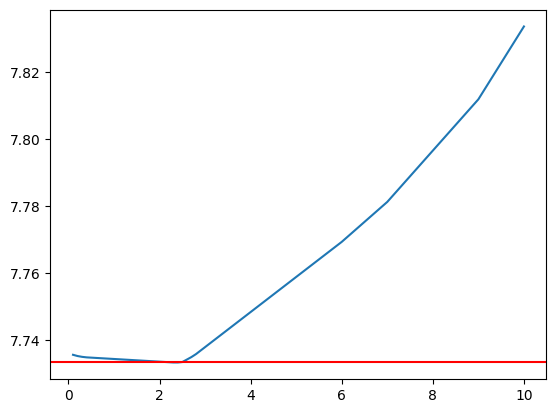

In [58]:
# mean avagarege deviation
y_est = model_lasso.predict(X_ext)
mad = np.mean(np.abs(y_est-y))
mad_data = []
for i in [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.8,1.9,2,2.1,2.2,2.3,2.4,2.5,2.6,2.7,2.8,2.9,3,4,5,6,7,8,9,10]:
    model_ridge = lm.Lasso(alpha=i).fit(X_ext,y)
    y_est = model_ridge.predict(X_ext)
    mad = np.mean(np.abs(y_est-y))
    mad_data.append([i,mad])
mad_data = pd.DataFrame(mad_data)
mad_data.columns = ['alpha','mad']
# sns.scatterplot(x=mad_data[:,0],y=mad_data[:,1])
plt.plot(mad_data['alpha'],mad_data['mad'])
plt.axhline(y=mad_data['mad'].min(),color='r')
plt.show()
    

check for web access . user name and password in the book.m
    